In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # using specific GPU
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from compatible.likelihoods import MultiClass, Gaussian
from compatible.kernels import RBF, White
from gpflow.models.svgp import SVGP
from gpflow.training import AdamOptimizer, ScipyOptimizer
from scipy.stats import mode
from scipy.cluster.vq import kmeans2
import gpflow
from gpflow.mean_functions import Identity, Linear
from gpflow.mean_functions import Zero
from gpflow import autoflow, params_as_tensors, ParamList
import pandas as pd
import itertools
pd.options.display.max_rows = 999
import gpflow_monitor

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.io import loadmat
from gpflow_monitor import *
print('tf_ver:', tf.__version__, 'gpflow_ver:', gpflow.__version__)
from tensorflow.python.client import device_lib
print('avail devices:\n'+'\n'.join([x.name for x in device_lib.list_local_devices()]))
from jack_utils.common import time_it
import sys
import gpflow.training.monitor as mon

# our impl
from dgp_graph import *

np.random.seed(1234)

tf_ver: 1.15.0 gpflow_ver: 1.5.0
avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:XLA_GPU:0


Using TensorFlow backend.


In [2]:
def agg_func(adj, batch_x):
    # adj(n, n),  batch_x（batch, n, feat）
    # out: selected(batch, n, n*feat)
    a_ = np.expand_dims(adj, axis=-1)
    x_ = np.expand_dims(batch_x, axis=1)  # 维度插入应该在node维度之前
    selected = a_*x_
    return selected.reshape(batch_x.shape[0], batch_x.shape[1], -1)

In [3]:
def gen_data(nn, dg=3, trainsize=500, testsize=100, ns=1.0):
    gmat = np.eye(nn)
    for i in range(nn):
        r = np.random.permutation(nn)
        gmat[i, r[:dg]] = 1
    gmat = np.minimum(1, gmat+gmat.T)
    gmat = gmat.astype('int32')
    
    X, Y = np.random.randn(trainsize+testsize, nn), np.random.randn(trainsize+testsize, nn)*ns
#     for i in range(nn):
#         X[:, i] += np.sin(i)*ns + i
#     Y=X+10
    for i in range(trainsize+testsize):
        for j in range(nn):
            connetedx = X[i, gmat[:, j] == 1]
            Y[i, j] += np.sum(connetedx)
            
    Xs, Ys = X[-testsize:, :], Y[-testsize:, :]
    X, Y = X[:trainsize, :], Y[:trainsize, :]
    
    # normalize Y
    mu_y = np.mean(Y, axis=0)
    std_y = np.std(Y, axis=0)
    
    Y = (Y-mu_y)/std_y
    Ys = (Ys-mu_y)/std_y
    
    return gmat, X, Y, Xs, Ys

In [4]:
nodes = 500
(gmat, trX, trY, Xs, Ys) = gen_data(nodes, dg=3, trainsize=500, testsize=200, ns=1.0)

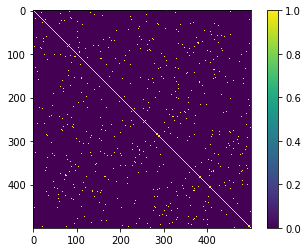

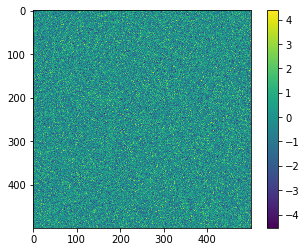

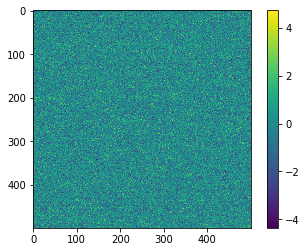

In [5]:
plt.figure(); plt.imshow(gmat); plt.colorbar()

plt.figure(); plt.imshow(trX); plt.colorbar()
plt.figure(); plt.imshow(trY); plt.colorbar()

In [6]:
M=50

Z = np.stack([kmeans2(trX[:,i], M, minit='points')[0] for i in range(nodes)],axis=1)  # (M=s2=10, n, d_in=5)
print('inducing points Z: {}'.format(Z.shape))

inducing points Z: (50, 500)


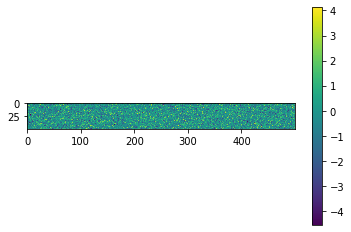

In [7]:
plt.imshow(Z); plt.colorbar()

In [8]:
node_id = 0

# Training

In [9]:
adj = gmat.astype('float64')
input_adj = adj # adj  / np.identity(adj.shape[0]) /  np.ones_like(adj)
with gpflow.defer_build():
    adj_dgpg = DGPG(trX[:,:,None], trY[:,:,None], Z[:,:,None], [1], Gaussian(), input_adj,
                  agg_op_name='concat3d', ARD=False,
                  is_Z_forward=True, mean_trainable=False, out_mf0=True,
                  num_samples=1, minibatch_size=None
                 )
    # m_sgp = SVGP(X, Y, kernels, Gaussian(), Z=Z, minibatch_size=minibatch_size, whiten=False)
adj_dgpg.compile()
model1 = adj_dgpg

input-output dim (1(agg:500)->1)
func __init__ consumed 0.6s


In [10]:
%%time

session = model1.enquire_session()
global_step = mon.create_global_step(session)

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

with mon.LogdirWriter('./exp/toy/tempx') as writer:
    tensorboard_task = mon.ModelToTensorBoardTask(writer, model1)\
        .with_name('tensorboard')\
        .with_condition(mon.PeriodicIterationCondition(100))\
        .with_exit_condition(True)
    monitor_tasks = [tensorboard_task] # [print_task, tensorboard_task]

    optimiser = gpflow.train.AdamOptimizer(0.01)
    
    with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
        optimiser.minimize(model1, step_callback=monitor, global_step=global_step, maxiter=1000)

Tasks execution time summary:
tensorboard:	15.7022 (sec)
CPU times: user 14h 49min 32s, sys: 7h 45min 9s, total: 22h 34min 41s
Wall time: 57min 2s


In [11]:
model1.as_pandas_table()

class prior         transform  \
DGPG/layers/0/feature/Z              Parameter  None            (none)   
DGPG/layers/0/kern/lengthscales      Parameter  None               +ve   
DGPG/layers/0/kern/variance          Parameter  None               +ve   
DGPG/layers/0/q_mu                   Parameter  None            (none)   
DGPG/layers/0/q_sqrt                 Parameter  None  LoTri_3d->matrix   
DGPG/likelihood/likelihood/variance  Parameter  None               +ve   

                                     trainable             shape  fixed_shape  \
DGPG/layers/0/feature/Z                   True    (50, 500, 500)         True   
DGPG/layers/0/kern/lengthscales           True            (500,)         True   
DGPG/layers/0/kern/variance               True            (500,)         True   
DGPG/layers/0/q_mu                        True      (500, 50, 1)         True   
DGPG/layers/0/q_sqrt                      True  (500, 1, 50, 50)         True   
DGPG/likelihood/likelihood/variance       True                ()         True   

                                                                                 value  
DGPG/layers/0/feature/Z              [[[0.8240594470350904, 0.0, -0.0, -0.0, 0.0, -...  
DGPG/layers/0/kern/lengthscales      [4.8398112859529165, 5.161590136088931, 4.7496...  
DGPG/layers/0/kern/variance          [0.8906178725961303, 0.9811908065280341, 1.347...  
DGPG/layers/0/q_mu                   [[[2.4689765287679957], [-0.6258036119240437],...  
DGPG/layers/0/q_sqrt                 [[[[0.10965974 0.         0.         0.       ...  
DGPG/likelihood/likelihood/variance                                0.13404550053897932

In [12]:
kzz1 = model1.layers[0].kern.compute_K_symm(model1.layers[0].feature.Z.value) # ~Kzz
print(kzz1.shape)

(500, 50, 50)


In [13]:
s1 = model1.layers[0].q_sqrt.value[node_id, 0] * model1.layers[0].q_sqrt.value[node_id, 0].T # ~S

Q1 = kzz1[node_id] - s1 # ~Q = ~Kzz - ~S

print(Q1.shape)

(50, 50)


In [14]:
X_agg1 = agg_func(adj, trX[:,:,None])
Z_agg1 = agg_func(adj, Z[:,:,None])

In [15]:
knxz1 = model1.layers[0].kern.compute_K(X_agg1, Z_agg1)

In [16]:
knxz1.shape

(500, 500, 50)

In [17]:
kxz1_lst = [np.linalg.norm(v) for v in knxz1[0]] # list of ~k

# mu_kxz1 = np.mean(knxz1[node_id], axis=0) # ~k

In [18]:
norm_kxz1 = np.mean(kxz1_lst) # \~k\

In [19]:
norm_kxz1 # \~k\

4.916453516788874

fully connected, no graph structure

In [20]:
adj_fc = np.ones_like(adj)
X_fc1 = agg_func(adj_fc, trX[:,:,None])
Z_fc1 = agg_func(adj_fc, Z[:,:,None])

In [21]:
knxz_fc1 = model1.layers[0].kern.compute_K(X_fc1, Z_fc1)

kxz2_lst = [np.linalg.norm(v) for v in knxz_fc1[0]] # list of k
norm_fc_kxz1 = np.mean(kxz2_lst) # \~k\
# mu_fc_kxz1 = np.mean(knxz_fc1[node_id], axis=0)
# norm_fc_kxz1 = np.linalg.norm(mu_fc_kxz1)

In [22]:
norm_fc_kxz1 # \k\

3.6787532585340337e-09

In [23]:
kzz1fc = model1.layers[0].kern.compute_K_symm(Z_fc1)
print(kzz1fc.shape)

(500, 50, 50)


In [24]:
Q1fc = kzz1fc[node_id] - s1

print(Q1fc.shape)

(50, 50)


# Result summary
With graph structure

In [25]:
np.set_printoptions(threshold=9999)

In [26]:
knxz1[0, node_id, :] # ~k(0)

array([0.485098  , 0.69164993, 0.76491862, 0.45829583, 0.76216909,
       0.67655817, 0.59577568, 0.73025458, 0.77636528, 0.73556979,
       0.59852081, 0.80639698, 0.5893865 , 0.63471736, 0.7099289 ,
       0.56871037, 0.72470614, 0.7250452 , 0.45901191, 0.55652297,
       0.61962993, 0.7352702 , 0.73434853, 0.54378638, 0.44337636,
       0.8169715 , 0.64445018, 0.76760638, 0.78593224, 0.56929807,
       0.84294267, 0.68721872, 0.65294218, 0.79638701, 0.54354825,
       0.78341282, 0.71677754, 0.70153501, 0.77227182, 0.62239739,
       0.65814943, 0.61679506, 0.53210548, 0.55018135, 0.68272545,
       0.72180932, 0.54711742, 0.66747591, 0.71809663, 0.64565781])

In [27]:
np.linalg.norm(knxz1[0, node_id, :]) # \~k(0)\

4.744795103514365

In [28]:
knxz_fc1.shape

(500, 500, 50)

In [29]:
knxz_fc1[0, node_id, :] # k(0)

array([3.83578945e-11, 1.25321359e-09, 3.84770636e-10, 2.79233503e-11,
       8.04597318e-12, 2.91576815e-10, 1.57010499e-10, 3.04422643e-10,
       2.96949953e-09, 7.73525010e-11, 1.34807356e-10, 6.87233265e-12,
       2.43641677e-11, 6.91425098e-11, 5.57053176e-11, 2.20730351e-10,
       1.66868517e-10, 2.84839755e-10, 4.20461903e-12, 9.43437605e-11,
       2.93405204e-11, 1.15940872e-10, 1.78301868e-10, 1.68445186e-11,
       1.53042125e-10, 8.60191703e-11, 9.77505347e-11, 1.63714618e-10,
       2.07061302e-10, 1.43008697e-10, 7.55056529e-11, 6.69916541e-11,
       6.90030587e-11, 1.99175945e-10, 3.34670783e-10, 9.51082205e-10,
       4.75390499e-11, 1.19463827e-09, 2.78447204e-10, 6.51563848e-10,
       4.10304159e-11, 4.26113042e-11, 4.58544354e-11, 4.38897741e-10,
       8.11644495e-09, 3.08522505e-10, 1.69056922e-10, 2.08756924e-10,
       3.69570616e-10, 4.57948803e-11])

In [30]:
np.linalg.norm(knxz_fc1[0, node_id, :]) # \k(0)\

8.97223334009071e-09

In [31]:
kzz1inv = np.linalg.inv(kzz1[node_id]) # ~Kzz^-1

In [32]:
M1 = kzz1inv * Q1 * kzz1inv # ~M = ~Kzz^-1 ~Q ~Kzz^-1

In [33]:
_, lamb1, _ = np.linalg.svd(M1)
print(lamb1) # ~lambda -> # ~lambda_min

[2.62739513e+07 1.01502889e+07 4.70453716e+06 2.16896617e+06
 9.00307351e+05 7.71893026e+05 7.28367754e+05 3.89300171e+05
 3.55643117e+05 3.26998042e+05 3.14947340e+05 2.84204320e+05
 1.92689006e+05 1.89807992e+05 1.61216949e+05 1.34436155e+05
 1.22578566e+05 1.13212077e+05 9.48467674e+04 8.87761411e+04
 7.20419182e+04 6.97018637e+04 6.82080811e+04 6.20593038e+04
 5.90493167e+04 5.59472206e+04 5.20313818e+04 4.93804963e+04
 4.47541563e+04 4.40007707e+04 4.14799973e+04 3.43434206e+04
 3.21500174e+04 2.89845426e+04 2.51970702e+04 2.21926549e+04
 2.02767253e+04 2.01479719e+04 1.91794007e+04 1.85650883e+04
 1.68808488e+04 1.57581999e+04 1.48531739e+04 1.43296412e+04
 1.26499014e+04 1.00110869e+04 9.49292768e+03 5.10281677e+03
 3.30443882e+03 4.84548655e+01]


Without graph structure

In [34]:
kzz1invfc = np.linalg.inv(kzz1fc[node_id]) # Kzz

In [35]:
M1fc = kzz1invfc * Q1fc * kzz1invfc

In [36]:
_, lamb1fc, _ = np.linalg.svd(M1fc)
print(lamb1fc)

[1.12237534 1.12167401 1.12159219 1.12157295 1.12139795 1.12105648
 1.12075561 1.12065214 1.1205806  1.12043992 1.11999553 1.11996591
 1.11937622 1.11928034 1.11928001 1.11884985 1.11842561 1.11839739
 1.11833659 1.11820527 1.11814768 1.11799097 1.11792366 1.11764174
 1.1174683  1.11728166 1.11711389 1.11685194 1.11644241 1.11629639
 1.11623522 1.11596061 1.11595718 1.11523867 1.11500622 1.11493149
 1.11485823 1.11412276 1.11394361 1.11386261 1.11357135 1.11354207
 1.11333487 1.11322201 1.11154976 1.11039409 1.10964863 1.10765557
 1.0984257  0.96851954]
